In [21]:
import pandas as pd

# Load both training and test CSV files
mass_train = pd.read_csv("archive/csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv("archive/csv/mass_case_description_test_set.csv")

# Combine the datasets for unified preprocessing
mass_df = pd.concat([mass_train, mass_test], axis=0).reset_index(drop=True)

# Select informative metadata features + label
selected_columns = [
    'image file path',        # Keep for future image vector matching
    'pathology',              # Target label (MALIGNANT / BENIGN)
    'breast_density',         # Numeric
    'left or right breast',   # Categorical (L/R)
    'mass margins',           # Categorical
    'subtlety'                # Numeric (lower = subtle, higher = obvious)
]

# Keep only selected columns
mass_df = mass_df[selected_columns]

# Show preview
print(mass_df.head())


                                                                                                                                                                image file path  \
0    Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm   
1   Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm   
3   Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/000000.dcm   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.3.6

In [22]:
# Drop rows with missing image paths or labels, drop rows with missing tabular features
mass_df = mass_df.dropna(subset=[
    'image file path',
    'pathology',
    'breast_density',
    'left or right breast',
    'subtlety',
    'mass margins',
])

print(f"Remaining samples: {len(mass_df)}")

Remaining samples: 1636


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = ['left or right breast', 'mass margins']

for col in categorical_cols:
    le = LabelEncoder()
    mass_df[col] = le.fit_transform(mass_df[col])
    label_encoders[col] = le  # Store encoders in case you want to inverse transform later

# Step 5: Encode the target variable (pathology)
mass_df['pathology'] = mass_df['pathology'].apply(lambda x: 1 if x == 'MALIGNANT' else 0)

# mass_df['pathology'] = mass_df['pathology'].map({
#     'MALIGNANT': 1,
#     'BENIGN': 0,
#     'BENIGN_WITHOUT_CALLBACK': 0
# })

In [24]:
mass_df.head()['image file path']

0      Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm
2       Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/000000.dcm
4    Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/000000.dcm
Name: image file path, dtype: object

In [25]:
import pandas as pd
import os

# Load dicom_info.csv
dicom_info_path = "archive/csv/dicom_info.csv"
dicom_info = pd.read_csv(dicom_info_path)
print(f"Loaded dicom_info.csv with {len(dicom_info)} entries")

# Step 1: Build UID → JPEG path map
uid_to_jpeg_map = {}
for _, row in dicom_info.iterrows():
    dicom_path = row.get('file_path', '')
    jpeg_path = row.get('image_path', '')
    
    if isinstance(dicom_path, str) and isinstance(jpeg_path, str) and dicom_path and jpeg_path:
        parts = dicom_path.split('/')
        if len(parts) >= 3 and 'dicom' in dicom_path:
            uid = parts[2]
            local_jpeg_path = jpeg_path.replace("CBIS-DDSM/jpeg/", "archive/jpeg/")
            uid_to_jpeg_map[uid] = local_jpeg_path

print(f"UID→JPEG mapping created for {len(uid_to_jpeg_map)} UIDs")

# Step 2: Mapping function
def extract_uid_and_map_to_jpeg(image_file_path):
    if not isinstance(image_file_path, str):
        return None
    parts = image_file_path.split('/')
    uids = parts[1:3] if len(parts) >= 3 else []
    for uid in uids:
        if uid in uid_to_jpeg_map:
            return uid_to_jpeg_map[uid]
    return None

# Step 3: Apply mapping to your metadata
mass_df['jpeg_path'] = mass_df['image file path'].apply(extract_uid_and_map_to_jpeg)

# Step 4: Drop any failed matches
mass_df = mass_df.dropna(subset=['jpeg_path'])

print(f"Final dataset has {len(mass_df)} rows with valid JPEG image paths")
print(mass_df[['image file path', 'jpeg_path']].head())


Loaded dicom_info.csv with 10237 entries
UID→JPEG mapping created for 6774 UIDs
Final dataset has 1636 rows with valid JPEG image paths
                                                                                                                                                                image file path  \
0    Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm   
1   Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm   
3   Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.29536092631349274544186

In [26]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4070 SUPER


In [27]:
# Set display width so full strings in DataFrame are shown
pd.set_option('display.max_colwidth', None)

# Then print the head
print(mass_df[['jpeg_path']].head())

                                                                                 jpeg_path
0  archive/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg
1  archive/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
2   archive/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg
3  archive/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg
4  archive/jpeg/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/1-056.jpg


In [28]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

# Step 1: Load pretrained ResNet-18 and remove final classification layer
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
resnet.eval()

# Step 2: Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Step 3: Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Step 4: Prepare storage for image vectors
image_vectors = []

# Step 5: Loop through each JPEG path
for img_path in tqdm(mass_df['jpeg_path'], desc="Vectorizing images"):
    try:
        # Open and convert image to RGB
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim

        # Forward pass through ResNet
        with torch.no_grad():
            vector = resnet(img_tensor).squeeze().cpu().numpy()  # Flatten

        image_vectors.append(vector)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        image_vectors.append(np.zeros(512))  # Fallback vector for errors

# Step 6: Convert to NumPy array
image_vectors = np.array(image_vectors)
print(f"Vectorized images shape: {image_vectors.shape}")  # (n_samples, 512)

# Save to CSV
np.savetxt("image_vectors_resnet18.csv", image_vectors, delimiter=",")
print("Saved image vectors to image_vectors_resnet18.csv")


c:\Users\azizi\anaconda3\envs\a510_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\azizi\anaconda3\envs\a510_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Vectorizing images: 100%|██████████| 1636/1636 [02:38<00:00, 10.31it/s]


Vectorized images shape: (1636, 512)
Saved image vectors to image_vectors_resnet18.csv


In [29]:
import pandas as pd

# Load image vectors (1634 rows × 512 columns)
image_vectors = pd.read_csv("image_vectors_resnet18.csv", header=None)

# Reset index just in case to align properly
mass_df = mass_df.reset_index(drop=True)

# Combine horizontally: metadata + image vectors
combined_df = pd.concat([mass_df, image_vectors], axis=1)

# Optionally save the full merged dataset
combined_df.to_csv("combined_metadata_and_image_vectors.csv", index=False)

print("Combined DataFrame shape:", combined_df.shape)
print(combined_df.head(2))


Combined DataFrame shape: (1636, 519)
                                                                                                                                                               image file path  \
0   Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm   

   pathology  breast_density  left or right breast  mass margins  subtlety  \
0          1               3                     0            18         4   
1          1               3                     0            18         4   

                                                                                 jpeg_path  \
0  archive/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg   
1  a

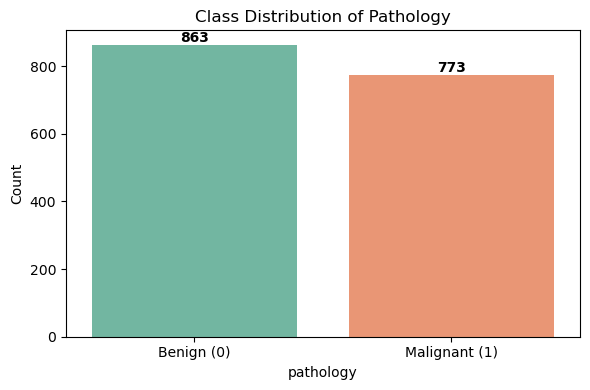

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each class
class_counts = combined_df['pathology'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")

# Add labels and title
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.ylabel('Count')
plt.title('Class Distribution of Pathology')

# Show values on top
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [31]:
# All features (drop non-numeric columns like paths)
X = combined_df.drop(columns=['pathology', 'image file path', 'jpeg_path'])

# Fix column name types
X.columns = X.columns.astype(str)

# Target variable
y = combined_df['pathology']

In [32]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [34]:
# Make Predictions
y_pred = rf_model.predict(X_test)


In [35]:
# Evaluate the model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Detailed report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7652439024390244
Confusion Matrix:
 [[144  29]
 [ 48 107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       173
           1       0.79      0.69      0.74       155

    accuracy                           0.77       328
   macro avg       0.77      0.76      0.76       328
weighted avg       0.77      0.77      0.76       328

